# Project 2 - CutMix 또는 Mixup 비교실험 하기

### 목표
- **CutMix와 Mixup을 적용한 데이터셋으로 ResNet 모델 훈련**
- **각 Augmentation 기법에 따른 성능 비교 분석**
- **기본 Augmentation, CutMix, MixUp 적용 결과 시각화**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

c:\Users\JDINO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (1) 데이터셋 준비

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='../tensorflow_datasets'
)

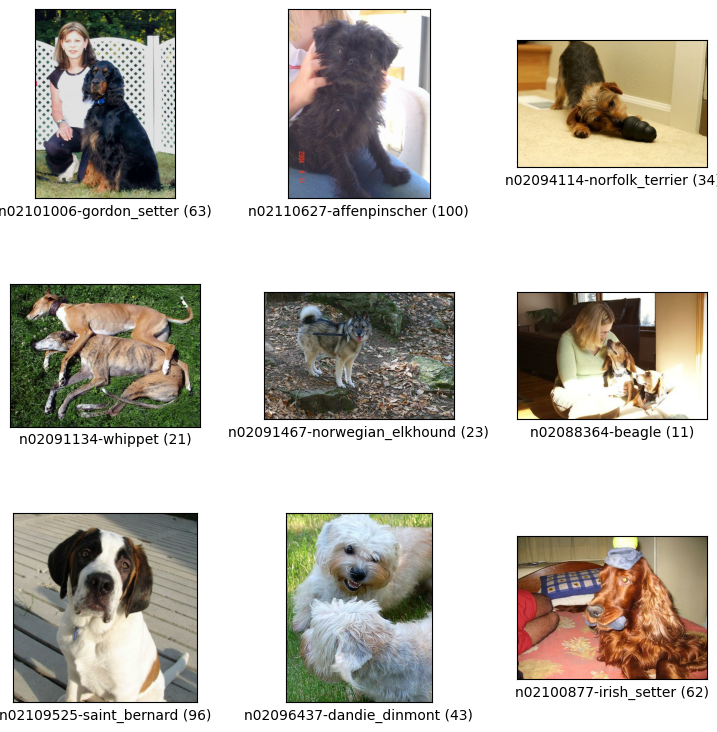

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

### (2) Augmentation 적용

- Normalization & Resizing

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

- Augmentation

In [6]:
def augment(image,label): # flip, brightness
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

- CutMix

In [21]:
# get image clip bound
def get_clip_box(image_a):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)
    
    return x_min, y_min, x_max, y_max

In [22]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    '''
    m_left    m_center  m_right   middle    top       bottom
    * * *     * * *     * * *     * * *     0 0 0     * * *
    0 * *     * 0 *     * * 0     0 0 0     * * *     * * *
    * * *     * * *     * * *     * * *     * * *     0 0 0
    '''
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_a의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [23]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    
    return mixed_label

In [24]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        
        image_b = image[j]
        label_b = label[j]
        
        x_min, y_min, x_max, y_max = get_clip_box(image_a)
        
        mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_label = mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max)
        
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

- Mixup

In [25]:
def mix_2_up(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    
    return mixed_image, mixed_label

In [26]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mix_2_up(image_a, image_b, label_a, label_b)
        
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

- One-hot Encoding

In [27]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

- Final data preprocessing

In [28]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,        # cutmix 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,         # mixup 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,        # onehot 인코딩 적용
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### (3) 모델 생성

In [29]:
num_classes = ds_info.features["label"].num_classes

In [30]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 마지막 클래스 수에 따른 fc layer
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [31]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [32]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [33]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### (4) 모델 훈련

In [34]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [35]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [37]:
with tf.device('/GPU:0'):
    no_aug_resnet50.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_no_aug_resnet50 = no_aug_resnet50.fit(
        ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    
    del no_aug_resnet50

Epoch 1/20
750/750 [==============================] - 164s 207ms/step - loss: 2.2041 - accuracy: 0.4484 - val_loss: 3.5615 - val_accuracy: 0.1867
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 0.7303 - accuracy: 0.7967 - val_loss: 1.2404 - val_accuracy: 0.6432
Epoch 3/20
750/750 [==============================] - 156s 209ms/step - loss: 0.2445 - accuracy: 0.9507 - val_loss: 0.9398 - val_accuracy: 0.7253
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0709 - accuracy: 0.9934 - val_loss: 0.9093 - val_accuracy: 0.7378
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0292 - accuracy: 0.9979 - val_loss: 0.8957 - val_accuracy: 0.7478
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0186 - accuracy: 0.9993 - val_loss: 0.9214 - val_accuracy: 0.7442
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0137 - accuracy: 0.9998 - val_loss: 0.9347 -

In [38]:
with tf.device('/GPU:0'):
    aug_resnet50.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_aug_resnet50 = aug_resnet50.fit(
        ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    
    del aug_resnet50

Epoch 1/20
750/750 [==============================] - 164s 210ms/step - loss: 2.2731 - accuracy: 0.4331 - val_loss: 2.9635 - val_accuracy: 0.2759
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 0.9522 - accuracy: 0.7249 - val_loss: 1.3710 - val_accuracy: 0.6094
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.5092 - accuracy: 0.8612 - val_loss: 1.0580 - val_accuracy: 0.6912
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.2834 - accuracy: 0.9304 - val_loss: 1.0923 - val_accuracy: 0.6872
Epoch 5/20
750/750 [==============================] - 156s 209ms/step - loss: 0.1502 - accuracy: 0.9704 - val_loss: 1.0155 - val_accuracy: 0.7113
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0901 - accuracy: 0.9858 - val_loss: 0.9729 - val_accuracy: 0.7292
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0527 - accuracy: 0.9927 - val_loss: 0.9402 -

In [39]:
with tf.device('/GPU:0'):
    cutmix_resnet50.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_cutmix_resnet50 = cutmix_resnet50.fit(
        ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    
    del cutmix_resnet50

Epoch 1/20
750/750 [==============================] - 166s 211ms/step - loss: 3.8617 - accuracy: 0.2025 - val_loss: 3.1862 - val_accuracy: 0.2436
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 3.0143 - accuracy: 0.4146 - val_loss: 1.3588 - val_accuracy: 0.6164
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 2.7346 - accuracy: 0.4931 - val_loss: 1.3737 - val_accuracy: 0.6136
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5414 - accuracy: 0.5550 - val_loss: 1.2036 - val_accuracy: 0.6670
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.4235 - accuracy: 0.5943 - val_loss: 1.2434 - val_accuracy: 0.6627
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2995 - accuracy: 0.6324 - val_loss: 1.3114 - val_accuracy: 0.6406
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2223 - accuracy: 0.6623 - val_loss: 1.1228 -

In [40]:
with tf.device('/GPU:0'):
    mixup_resnet50.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_mixup_resnet50 = mixup_resnet50.fit(
        ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    
    del mixup_resnet50

Epoch 1/20
750/750 [==============================] - 166s 211ms/step - loss: 3.7351 - accuracy: 0.2407 - val_loss: 3.4045 - val_accuracy: 0.2066
Epoch 2/20
750/750 [==============================] - 158s 210ms/step - loss: 2.9290 - accuracy: 0.4490 - val_loss: 1.5564 - val_accuracy: 0.5625
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 2.6722 - accuracy: 0.5434 - val_loss: 1.2673 - val_accuracy: 0.6386
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5126 - accuracy: 0.6030 - val_loss: 1.4074 - val_accuracy: 0.6135
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3997 - accuracy: 0.6444 - val_loss: 1.3335 - val_accuracy: 0.6361
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2945 - accuracy: 0.6877 - val_loss: 1.3164 - val_accuracy: 0.6344
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2149 - accuracy: 0.7140 - val_loss: 1.1524 -

### (5) 훈련 과정 시각화

In [41]:
import matplotlib.pyplot as plt

# Loss and val_loss from each history
histories = [history_no_aug_resnet50.history,
             history_aug_resnet50.history,
             history_cutmix_resnet50.history,
             history_mixup_resnet50.history]

# Labels for different training settings
labels = ['No Aug', 'Aug', 'CutMix', 'Mixup']

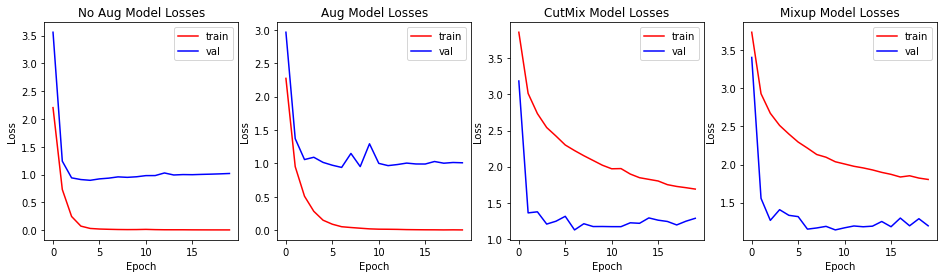

In [52]:
plt.figure(figsize=(16, 4))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.plot(histories[i]['loss'], 'r')
    plt.plot(histories[i]['val_loss'], 'b')
    plt.title(f'{labels[i]} Model Losses')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')

plt.show()

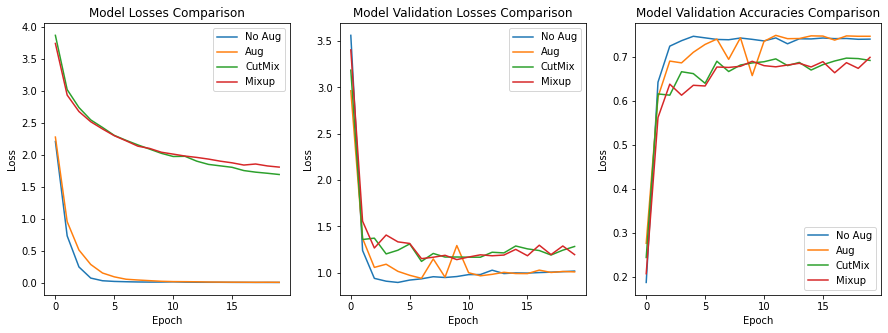

In [53]:
plt.figure(figsize=(15, 5))

# train loss graph
plt.subplot(1, 3, 1)
plt.plot(histories[0]['loss'])
plt.plot(histories[1]['loss'])
plt.plot(histories[2]['loss'])
plt.plot(histories[3]['loss'])
plt.title('Model Losses Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels, loc='upper right')

# validation loss graph
plt.subplot(1, 3, 2)
plt.plot(histories[0]['val_loss'])
plt.plot(histories[1]['val_loss'])
plt.plot(histories[2]['val_loss'])
plt.plot(histories[3]['val_loss'])
plt.title('Model Validation Losses Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels, loc='upper right')

# validation accuracy graph
plt.subplot(1, 3, 3)
plt.plot(histories[0]['val_accuracy'])
plt.plot(histories[1]['val_accuracy'])
plt.plot(histories[2]['val_accuracy'])
plt.plot(histories[3]['val_accuracy'])
plt.title('Model Validation Accuracies Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels, loc='lower right')

plt.show()

### (6) Augmentation에 의한 모델 성능 비교

- cutmix, mixup은 no_aug, aug와는 다르게 train loss가 validation loss보다 높게 나타났다.
- 그리고 4가지 모델의 validation loss는 cutmix, mixup이 살짝 높긴 하지만 전체적으로 비슷한 경향을 나타내었다.
- 이는 이미지를 섞어서 학습을 시켜도 정제가 되어있지 않은 validation dataset에 대해 좋은 성능을 나타낸다는 것을 의미한다.